In [9]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math
import time


In [10]:
import lightgbm as lgb

In [11]:
data = pd.read_csv(r'/Users/jacquelin/Documents/python/金融风控实战/Bcard.txt')
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [12]:
data.shape

(95806, 13)

In [13]:
#看一下月份分布，我们用最后一个月做为跨时间验证集合
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [14]:
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

In [15]:
#这是我们全部的变量，info结尾的是自己做的无监督系统输出的个人表现，score结尾的是收费的外部征信数据
lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']

In [16]:
#df_train = df_train.sort_values(by = 'obs_mth',ascending = False)
df_train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [17]:
df_train = df_train.sort_values(by = 'obs_mth',ascending = False)

rank_lst = []
for i in range(1,len(df_train)+1):
    rank_lst.append(i)
    
df_train['rank'] = rank_lst

df_train['rank'] = df_train['rank']/len(df_train)

pct_lst = []
for x in df_train['rank']:
    if x <= 0.2:
        x = 1
    elif x <= 0.4:
        x = 2
    elif x <= 0.6:
        x = 3
    elif x <= 0.8:
        x = 4
    else:
        x = 5
    pct_lst.append(x)
df_train['rank'] = pct_lst        
#train = train.drop('obs_mth',axis = 1)
df_train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,rank
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949,1
33407,33407,2018-10-31,0.0,A2810176,0.146055,0.079922,0.250568,0.045240,0.766906,0.413713,0.013863,0.023810,0.00,0.269231,1
33383,33383,2018-10-31,0.0,A2807687,0.551366,0.300781,0.225007,0.045447,0.735733,0.684182,-0.261014,0.071429,0.03,0.269231,1
33379,33379,2018-10-31,0.0,A2807232,0.708547,0.769513,0.928457,0.739716,0.947453,0.361551,-0.128677,0.047619,0.00,0.269231,1
33376,33376,2018-10-31,0.0,A2806932,0.482248,0.116658,0.286273,0.056618,0.047024,0.890433,0.078853,0.047619,0.00,0.269231,1


In [18]:
df_train['rank'].groupby(df_train['rank']).count()

rank
1    15966
2    15966
3    15966
4    15966
5    15967
Name: rank, dtype: int64

bin_record = pd.DataFrame()
for col in col_lst:
    cb.pct_bin(data,col,'label')
    cb.plot_woe()
    data[col] = cb.trans_to_woe(data[col])
    rcd = cb.get_bin_stats()
    if bin_record.empty:
        bin_record = rcd
    else:
        bin_record = bin_record.append(rcd)
bin_record.head(8)

In [19]:
len(df_train)

79831

In [20]:
print(set(df_train['rank']))

{1, 2, 3, 4, 5}


In [21]:
#定义lgb函数
def LGB_test(train_x,train_y,test_x,test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=2, n_estimators=80,max_features = 140, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50,random_state=None,n_jobs=cpu_count()-1,
        num_iterations = 80 #迭代次数
    )
    clf.fit(train_x, train_y,eval_set=[(train_x, train_y),(test_x,test_y)],eval_metric='auc',early_stopping_rounds=100)
    print(clf.n_features_)

    return clf,clf.best_score_[ 'valid_1']['auc']

In [22]:

feature_lst = {}
ks_train_lst = []
ks_test_lst = []
for rk in set(df_train['rank']):   
    
    # 测试集8.18以后作为跨时间验证集
    
    #定义模型训练集与测试集
    #在第一轮，rank为1的作为测试集，其他4份为训练集，for循环5次进行5轮
    ttest = df_train[df_train['rank'] ==  rk]
    ttrain = df_train[df_train['rank'] !=  rk]
    
    train = ttrain[lst]
    train_y = ttrain.bad_ind
    
    test = ttest[lst]
    test_y = ttest.bad_ind    
    
    start = time.time()
    model,auc = LGB_test(train,train_y,test,test_y)                    
    end = time.time()
    
    #模型贡献度放在feature中
    feature = pd.DataFrame(
                {'name' : model.booster_.feature_name(),
                'importance' : model.feature_importances_
              }).sort_values(by =  ['importance'],ascending = False)
    #print(feature)
    
       
    #计算训练集、测试集、验证集上的KS和AUC

    y_pred_train_lgb = model.predict_proba(train)[:, 1]
    y_pred_test_lgb = model.predict_proba(test)[:, 1]


    train_fpr_lgb, train_tpr_lgb, _ = roc_curve(train_y, y_pred_train_lgb)
    test_fpr_lgb, test_tpr_lgb, _ = roc_curve(test_y, y_pred_test_lgb)


    train_ks = abs(train_fpr_lgb - train_tpr_lgb).max()
    test_ks = abs(test_fpr_lgb - test_tpr_lgb).max()


    train_auc = metrics.auc(train_fpr_lgb, train_tpr_lgb)
    test_auc = metrics.auc(test_fpr_lgb, test_tpr_lgb)
    
    ks_train_lst.append(train_ks)
    ks_test_lst.append(test_ks)    

    feature_lst[str(rk)] = feature[feature.importance>=20].name

train_ks = np.mean(ks_train_lst)
test_ks = np.mean(ks_test_lst)

ft_lst = {}
for i in range(1,6):
    ft_lst[str(i)] = feature_lst[str(i)]
#print(feature_lst)
#5轮重要特征取交集
fn_lst=list(set(ft_lst['1']) & set(ft_lst['2'])& set(ft_lst['3']) & set(ft_lst['4']) &set(ft_lst['5']))

print('train_ks: ',train_ks)
print('test_ks: ',test_ks)

print('ft_lst: ',fn_lst )


/Users/jacquelin/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.737137	training's binary_logloss: 0.0832707	valid_1's auc: 0.712178	valid_1's binary_logloss: 0.12168
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.779956	training's binary_logloss: 0.0821329	valid_1's auc: 0.773038	valid_1's binary_logloss: 0.119538
[3]	training's auc: 0.787657	training's binary_logloss: 0.0816239	valid_1's auc: 0.759829	valid_1's binary_logloss: 0.118773
[4]	training's auc: 0.787083	training's binary_logloss: 0.0811169	valid_1's auc: 0.758327	valid_1's binary_logloss: 0.117919
[5]	training's auc: 0.791363	training's binary_logloss: 0.0803378	valid_1's auc: 0.768679	valid_1's binary_logloss: 0.116488
[6]	training's auc: 0.797614	training's binary_logloss: 0.0796057	valid_1's auc: 0.779753	valid_1's binary_logloss: 0.11516
[7]	training's auc: 0.796785	training's binary_logloss: 0.0792409	valid_1's auc: 0.779428	valid_1's binary_logloss: 0.114638
[8]	training's auc: 0.799178	training's binary_logloss: 0.0786552

[1]	training's auc: 0.741457	training's binary_logloss: 0.0863868	valid_1's auc: 0.713623	valid_1's binary_logloss: 0.109309
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.78475	training's binary_logloss: 0.0852072	valid_1's auc: 0.771443	valid_1's binary_logloss: 0.107672
[3]	training's auc: 0.789005	training's binary_logloss: 0.0846673	valid_1's auc: 0.773894	valid_1's binary_logloss: 0.107001
[4]	training's auc: 0.785614	training's binary_logloss: 0.0841296	valid_1's auc: 0.768015	valid_1's binary_logloss: 0.106362
[5]	training's auc: 0.79808	training's binary_logloss: 0.0832829	valid_1's auc: 0.782823	valid_1's binary_logloss: 0.105157
[6]	training's auc: 0.798957	training's binary_logloss: 0.0825228	valid_1's auc: 0.783147	valid_1's binary_logloss: 0.104134
[7]	training's auc: 0.799081	training's binary_logloss: 0.0821122	valid_1's auc: 0.781683	valid_1's binary_logloss: 0.103707
[8]	training's auc: 0.799412	training's binary_logloss: 0.0814982

[1]	training's auc: 0.730347	training's binary_logloss: 0.0973531	valid_1's auc: 0.746153	valid_1's binary_logloss: 0.0662543
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.784643	training's binary_logloss: 0.0959369	valid_1's auc: 0.790691	valid_1's binary_logloss: 0.0654012
[3]	training's auc: 0.789082	training's binary_logloss: 0.0953758	valid_1's auc: 0.802344	valid_1's binary_logloss: 0.0649805
[4]	training's auc: 0.786326	training's binary_logloss: 0.0948066	valid_1's auc: 0.799455	valid_1's binary_logloss: 0.0645839
[5]	training's auc: 0.791919	training's binary_logloss: 0.0938076	valid_1's auc: 0.805947	valid_1's binary_logloss: 0.0638862
[6]	training's auc: 0.791494	training's binary_logloss: 0.0930058	valid_1's auc: 0.804091	valid_1's binary_logloss: 0.0633804
[7]	training's auc: 0.792345	training's binary_logloss: 0.0926092	valid_1's auc: 0.804251	valid_1's binary_logloss: 0.0630972
[8]	training's auc: 0.793064	training's binary_logloss: 

[1]	training's auc: 0.730749	training's binary_logloss: 0.0961633	valid_1's auc: 0.742913	valid_1's binary_logloss: 0.0709548
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.784028	training's binary_logloss: 0.0947491	valid_1's auc: 0.797433	valid_1's binary_logloss: 0.0699955
[3]	training's auc: 0.788859	training's binary_logloss: 0.0942243	valid_1's auc: 0.804463	valid_1's binary_logloss: 0.0695991
[4]	training's auc: 0.788094	training's binary_logloss: 0.0936544	valid_1's auc: 0.800355	valid_1's binary_logloss: 0.069149
[5]	training's auc: 0.793122	training's binary_logloss: 0.0926345	valid_1's auc: 0.803236	valid_1's binary_logloss: 0.068461
[6]	training's auc: 0.794215	training's binary_logloss: 0.0917177	valid_1's auc: 0.80357	valid_1's binary_logloss: 0.0678381
[7]	training's auc: 0.794273	training's binary_logloss: 0.0913001	valid_1's auc: 0.802532	valid_1's binary_logloss: 0.0674945
[8]	training's auc: 0.794774	training's binary_logloss: 0.0

[1]	training's auc: 0.7369	training's binary_logloss: 0.0916053	valid_1's auc: 0.7262	valid_1's binary_logloss: 0.088886
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.793624	training's binary_logloss: 0.0901081	valid_1's auc: 0.767404	valid_1's binary_logloss: 0.0878256
[3]	training's auc: 0.798711	training's binary_logloss: 0.0895489	valid_1's auc: 0.774005	valid_1's binary_logloss: 0.0873619
[4]	training's auc: 0.799412	training's binary_logloss: 0.0890054	valid_1's auc: 0.77414	valid_1's binary_logloss: 0.0869067
[5]	training's auc: 0.803779	training's binary_logloss: 0.0880829	valid_1's auc: 0.776585	valid_1's binary_logloss: 0.0862555
[6]	training's auc: 0.804211	training's binary_logloss: 0.087227	valid_1's auc: 0.776126	valid_1's binary_logloss: 0.0856483
[7]	training's auc: 0.803314	training's binary_logloss: 0.0868094	valid_1's auc: 0.775453	valid_1's binary_logloss: 0.0852977
[8]	training's auc: 0.804279	training's binary_logloss: 0.08609

/Users/jacquelin/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.735642	training's binary_logloss: 0.091006	valid_1's auc: 0.724797	valid_1's binary_logloss: 0.0992666
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.789312	training's binary_logloss: 0.0896377	valid_1's auc: 0.764213	valid_1's binary_logloss: 0.0978427
[3]	training's auc: 0.791924	training's binary_logloss: 0.0883854	valid_1's auc: 0.767788	valid_1's binary_logloss: 0.0964733
[4]	training's auc: 0.792844	training's binary_logloss: 0.0874345	valid_1's auc: 0.767467	valid_1's binary_logloss: 0.0954996
[5]	training's auc: 0.792178	training's binary_logloss: 0.0866018	valid_1's auc: 0.768703	valid_1's binary_logloss: 0.0946422
[6]	training's auc: 0.793624	training's binary_logloss: 0.0861442	valid_1's auc: 0.770601	valid_1's binary_logloss: 0.0941544
[7]	training's auc: 0.793346	training's binary_logloss: 0.0857377	valid_1's auc: 0.771983	valid_1's binary_logloss: 0.0937597
[8]	training's auc: 0.793341	training's binary_logloss: 0

train_ks :  0.48729706147207924
evl_ks :  0.43312693775943956


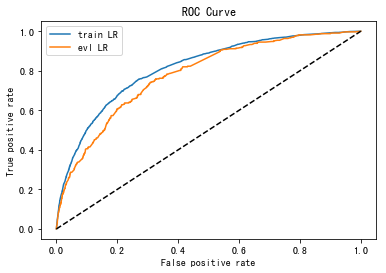

In [23]:
lst = ['person_info','finance_info','credit_info','act_info']

train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
evl = data[data.obs_mth == '2018-11-30'].reset_index().copy()

x = train[lst]
y = train['bad_ind']

evl_x =  evl[lst]
evl_y = evl['bad_ind']

model,auc = LGB_test(x,y,evl_x,evl_y)

y_pred = model.predict_proba(x)[:,1]
fpr_lgb_train,tpr_lgb_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lgb_train - tpr_lgb_train).max()
print('train_ks : ',train_ks)

y_pred = model.predict_proba(evl_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(evl_y,y_pred)
evl_ks = abs(fpr_lgb - tpr_lgb).max()
print('evl_ks : ',evl_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lgb_train,tpr_lgb_train,label = 'train LR')
plt.plot(fpr_lgb,tpr_lgb,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [24]:
#['person_info','finance_info','credit_info','act_info']
#算分数onekey 
def score(xbeta):
    score = 1000-500*(math.log2(1-xbeta)/xbeta)  #好人的概率/坏人的概率
    return score
evl['xbeta'] = model.predict_proba(evl_x)[:,1]   
evl['score'] = evl.apply(lambda x : score(x.xbeta) ,axis=1)

In [25]:
fpr_lr,tpr_lr,_ = roc_curve(evl_y,evl['score'])
evl_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',evl_ks)

val_ks :  0.43312693775943956


In [26]:
#生成报告
row_num, col_num = 0, 0
bins = 20
Y_predict = evl['score']
Y = evl_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows/bins+1)
bad = sum([1 for (p, y) in ks_lis if y > 0.5])
good = sum([1 for (p, y) in ks_lis if y <= 0.5])
bad_cnt, good_cnt = 0, 0
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0.5])
    good1 = sum([1 for (p, y) in ds if y <= 0.5])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(evl_y),3)
    badrate = round(bad1/(bad1+good1),3)
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.235,92,707,92,707,0.280,0.115
1,0.299,37,762,129,1469,0.393,0.046
2,0.336,28,771,157,2240,0.479,0.035
3,0.393,35,764,192,3004,0.585,0.044
4,0.398,18,781,210,3785,0.640,0.023
5,0.419,23,776,233,4561,0.710,0.029
6,0.421,17,782,250,5343,0.762,0.021
7,0.404,11,788,261,6131,0.796,0.014
8,0.381,9,790,270,6921,0.823,0.011
9,0.370,13,786,283,7707,0.863,0.016


In [31]:
from pyecharts.charts import *
from pyecharts import options as opts

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()